In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate

In [2]:
df = pd.read_csv("sample_data_3.csv")

C:\Users\siddh\AppData\Local\Temp\ipykernel_5424\2753632433.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sample_data_3.csv")


In [3]:
df.head()
df.isnull().sum()


Time                     0
Rev_ME                   2
CppPitch                 2
FO_ME_Cons               2
FO_GE_Cons               2
                        ..
STAND_BY_ETHRNET_LINE    0
STAND_BY_ILS_LINE        0
ILS_ETH_LINE1            0
ILS_ETH_LINE2            0
frag_port                0
Length: 68, dtype: int64

In [4]:
#Ensures pandas recognizes the column as dates/times, not just text. So coverting it to pd datetime frame
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time')

In [5]:
print("Start Time:", df['Time'].min())
print("End Time:", df['Time'].max())
print("Data Frequency:", df['Time'].diff().mode()[0])

Start Time: 2024-03-05 00:00:00
End Time: 2024-06-05 23:59:00
Data Frequency: 0 days 00:01:00


In [6]:
#Continuous fuel consumption records
for col in ['FO_ME_Cons', 'FO_GE_Cons']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(method='ffill')

#Forward-filling assumes stable conditions between readings
numeric_cols = ['Ship_Speed', 'CppPitch', 'Wind_Speed', 'HEEL', 'Fore_Draft', 'Aft_Draft']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(method='ffill')

#Removes rows with critical data gaps
df = df.dropna(subset=numeric_cols + ['FO_ME_Cons', 'FO_GE_Cons'])

#Removes idle/port states (speed ≤0.5 knots) Improves model relevance to voyage efficiency
df = df[df['Ship_Speed'] > 0.5]

C:\Users\siddh\AppData\Local\Temp\ipykernel_5424\2608474793.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(method='ffill')
C:\Users\siddh\AppData\Local\Temp\ipykernel_5424\2608474793.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(method='ffill')


In [7]:
#so we calculate fuel consumption per row (per minute):
fuel_me = df['FO_ME_Cons'].diff().clip(lower=0)
fuel_ge = df['FO_GE_Cons'].diff().clip(lower=0)
df['Fuel_Liters'] = fuel_me + fuel_ge
#calculating Trim
df['Trim'] = df['Aft_Draft'] - df['Fore_Draft']
#calculating Average Draft
df['Avg_Draft'] = (df['Aft_Draft'] + df['Fore_Draft']) / 2

In [8]:
df.to_csv("Cleaned_RO-RO_Data.csv", index=False)

In [9]:
# Gross tonnage of RO-RO ship got this from Tsuruta San
GT = 14052
# HFO density in kg/L from IMO (International Maritime Organization) 
FUEL_DENSITY = 0.991  
# g CO2 per gram of HFO from IMO (International Maritime Organization) 
CO2_FACTOR = 3.114  

In [10]:
fuel_kg = df['Fuel_Liters'] * FUEL_DENSITY
df['CO2_Emission_g'] = fuel_kg * 1000 * CO2_FACTOR  # convert kg to grams
df['Distance_NM'] = df['Ship_Speed'] / 60  # NM per minute

In [11]:
#now we group by month and compute total CO₂, distance, and average values for other relevant features.
df['Month_Year'] = df['Time'].dt.to_period('M')
monthly_df = df.groupby('Month_Year').agg({
    'CO2_Emission_g': 'sum',
    'Distance_NM': 'sum',
    'Ship_Speed': 'mean',
    'Wind_Speed': 'mean',
    'CppPitch': 'mean',
    'HEEL': 'mean',
    'Trim': 'mean',
    'Avg_Draft': 'mean'
}).reset_index()

In [12]:
monthly_df.rename(columns={
    'Ship_Speed': 'Avg_Speed',
    'Wind_Speed': 'Avg_Wind_Speed',
    'CppPitch': 'Avg_CppPitch',
    'HEEL': 'Avg_Heel',
    'Trim': 'Avg_Trim',
    'Avg_Draft': 'Avg_Draft'
}, inplace=True)

In [13]:
monthly_df.to_csv('monthly_summary.csv', index=False)
#With monthly aggregation, you have just 4 rows, which is far too little for training any meaningful ML model

In [14]:
#So now I am considering to Use weekly aggregation gives ~16 samples We can still predict annual CII from 1 week’s worth of data by upscaling

df['Week'] = df['Time'].dt.to_period('W')
weekly_df = df.groupby('Week').agg({
    'CO2_Emission_g': 'sum',
    'Distance_NM': 'sum',
    'Ship_Speed': 'mean',
    'Wind_Speed': 'mean',
    'CppPitch': 'mean',
    'HEEL': 'mean',
    'Trim': 'mean',
    'Avg_Draft': 'mean'
}).reset_index()

In [15]:
weekly_df.rename(columns={
    'Ship_Speed': 'Avg_Speed',
    'Wind_Speed': 'Avg_Wind_Speed',
    'CppPitch': 'Avg_CppPitch',
    'HEEL': 'Avg_Heel',
    'Trim': 'Avg_Trim',
    'Avg_Draft': 'Avg_Draft'
}, inplace=True)

In [16]:
weekly_df.to_csv('weekly_summary.csv', index=False)

In [17]:
df['Day'] = df['Time'].dt.to_period('D')
daily_df = df.groupby('Day').agg({
    'CO2_Emission_g': 'sum',
    'Distance_NM': 'sum',
    'Ship_Speed': 'mean',
    'Wind_Speed': 'mean',
    'CppPitch': 'mean',
    'HEEL': 'mean',
    'Trim': 'mean',
    'Avg_Draft': 'mean'
}).reset_index()

In [18]:
daily_df.rename(columns={
    'Ship_Speed': 'Avg_Speed',
    'Wind_Speed': 'Avg_Wind_Speed',
    'CppPitch': 'Avg_CppPitch',
    'HEEL': 'Avg_Heel',
    'Trim': 'Avg_Trim',
    'Avg_Draft': 'Avg_Draft'
}, inplace=True)

In [19]:
#Calculate projected annual emissions and distance
daily_df['Annual_CO2'] = daily_df['CO2_Emission_g'] * 365
daily_df['Annual_Dist'] = daily_df['Distance_NM'] * 365
#Calculate CII using the IMO formula
daily_df['CII'] = daily_df['Annual_CO2'] / (GT * daily_df['Annual_Dist'])
daily_df.to_csv('daily_summary.csv', index=False)

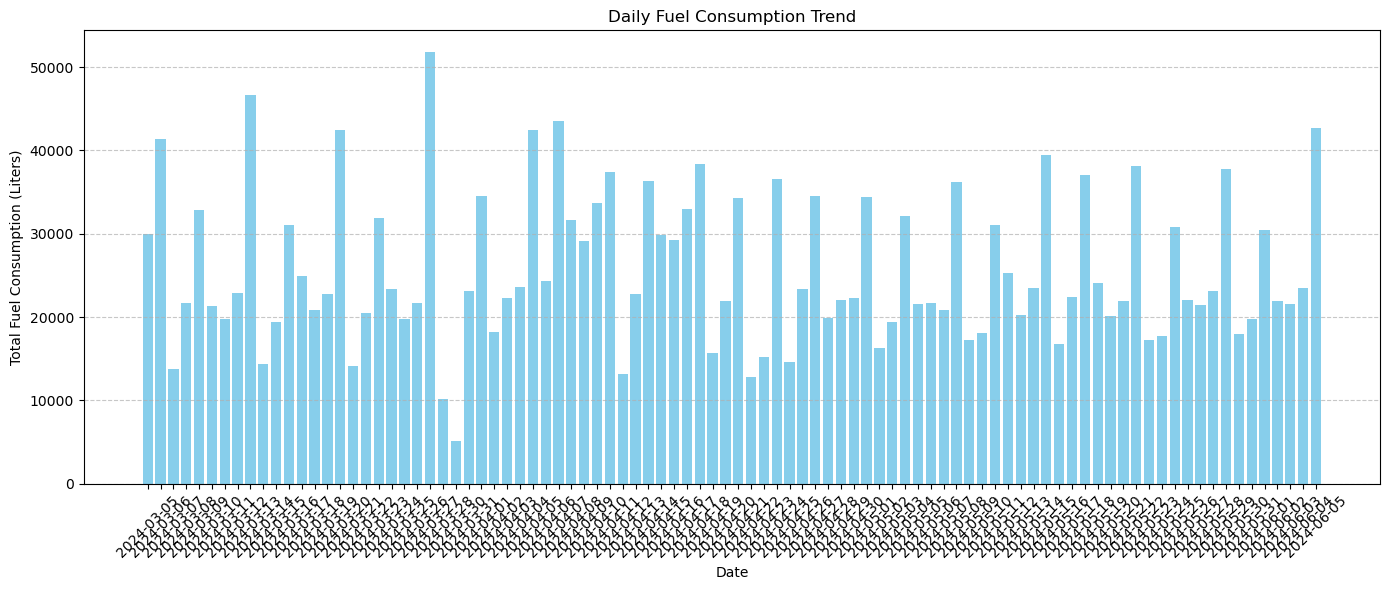

In [20]:
# Extract just the date
df['Day'] = df['Time'].dt.to_period('D')

# Calculate total fuel per day
daily_fuel = df.groupby('Day')['Fuel_Liters'].sum().reset_index()
daily_fuel.rename(columns={'Fuel_Liters': 'Total_Fuel_Liters'}, inplace=True)

# Merge it with your existing daily_df
daily_df = pd.merge(daily_df, daily_fuel, on='Day', how='left')


plt.figure(figsize=(14, 6))
plt.bar(daily_df['Day'].astype(str), daily_df['Total_Fuel_Liters'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Total Fuel Consumption (Liters)')
plt.title('Daily Fuel Consumption Trend')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

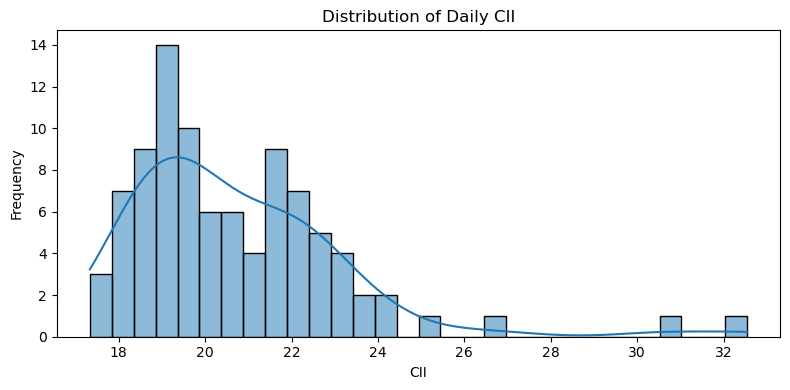

In [21]:
plt.figure(figsize=(8, 4))
sns.histplot(daily_df['CII'], kde=True, bins=30)
plt.title("Distribution of Daily CII")
plt.xlabel("CII")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

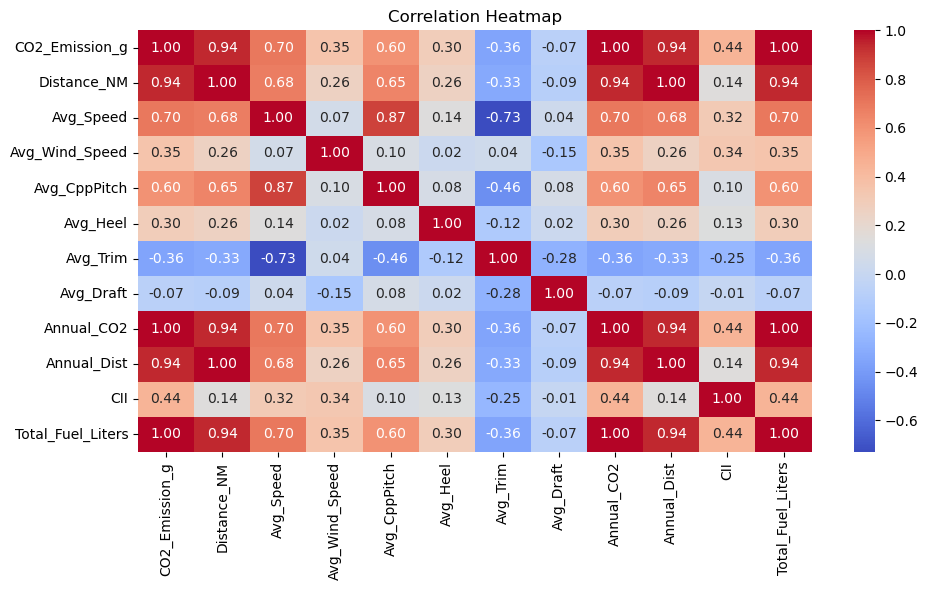

In [22]:
#Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(daily_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

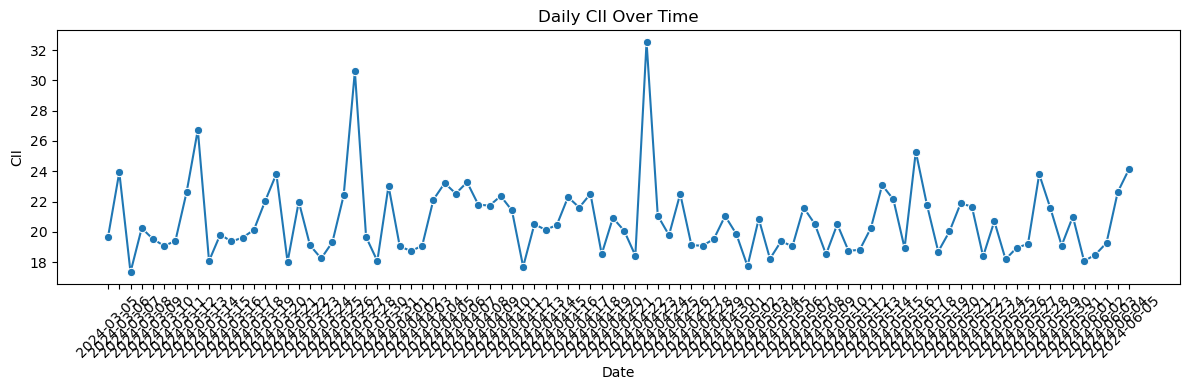

In [23]:
#CII over time
plt.figure(figsize=(12, 4))
sns.lineplot(x=daily_df['Day'].astype(str), y=daily_df['CII'], marker='o')
plt.xticks(rotation=45)
plt.title("Daily CII Over Time")
plt.xlabel("Date")
plt.ylabel("CII")
plt.tight_layout()
plt.show()

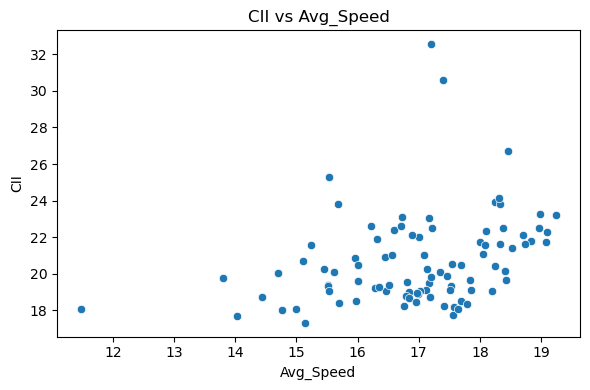

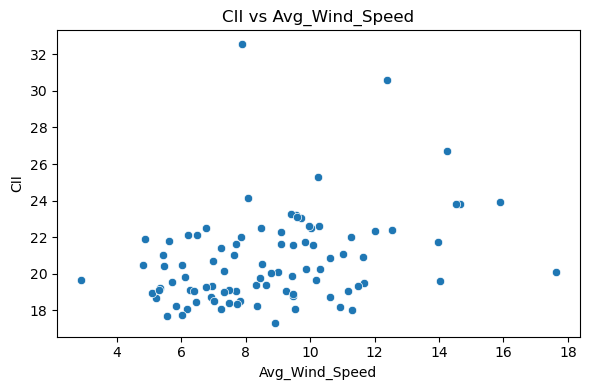

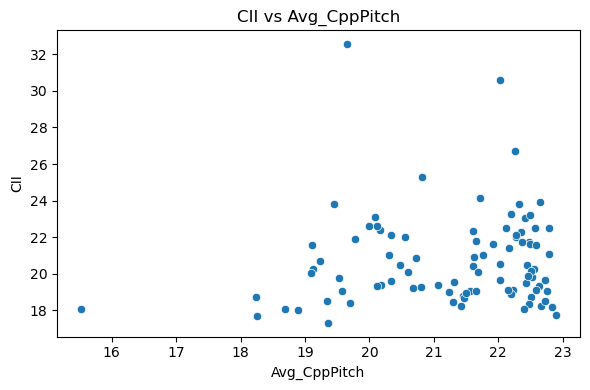

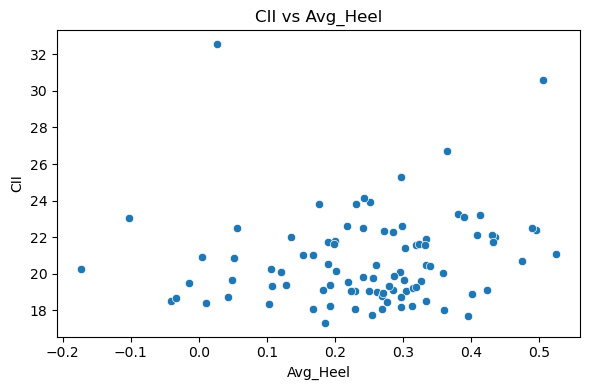

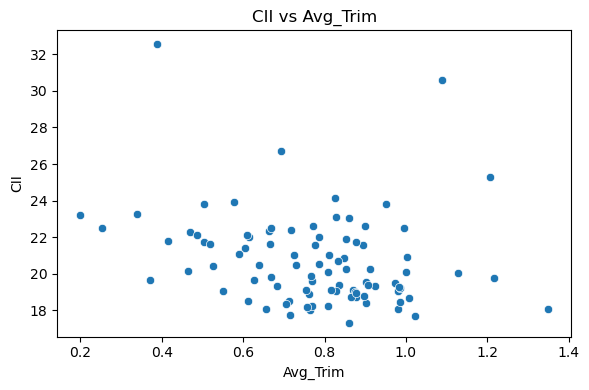

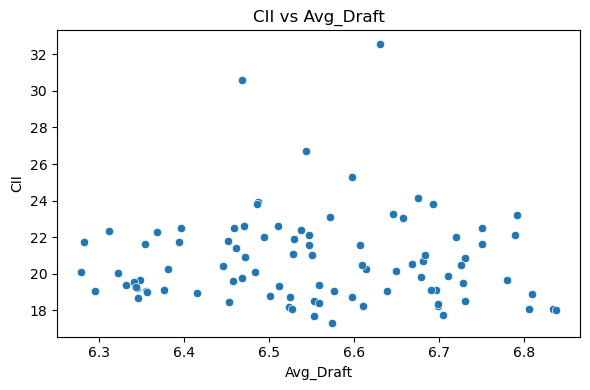

In [24]:
#CII vs Key Features
key_features = ['Avg_Speed', 'Avg_Wind_Speed', 'Avg_CppPitch', 'Avg_Heel', 'Avg_Trim', 'Avg_Draft']

for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=daily_df, x=feature, y='CII')
    plt.title(f"CII vs {feature}")
    plt.tight_layout()
    plt.show()

In [25]:
# Feature columns
features = [
    'CO2_Emission_g',
    'Distance_NM',
    'Avg_Speed',
    'Avg_Wind_Speed',
    'Avg_CppPitch',
    'Avg_Heel',
    'Avg_Trim',
    'Avg_Draft'
]

In [26]:
# Features (X) and Target (y)
X = daily_df[features]
y = daily_df['CII']

In [27]:
# Train-test split (we'll keep 80% for training, 20% for testing)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Time-based train-test split
split_index = int(len(daily_df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=0),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=0)
}

cv = KFold(n_splits=5, shuffle=True, random_state=1)
results = {}

In [30]:
for name, model in models.items():
    if name == 'Random Forest':
        scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
    else:
        scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv)
    results[name] = -scores.mean()
    print(f"{name} RMSE: {results[name]:.4f}")

best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

if best_model_name == 'Random Forest':
    best_model.fit(X_train, y_train)
    test_pred = best_model.predict(X_test)
else:
    best_model.fit(X_train_scaled, y_train)
    test_pred = best_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"\nBest model is: {best_model_name} with test RMSE = {rmse:.4f}")

Linear Regression RMSE: 1.2526
Ridge Regression RMSE: 1.2918
Random Forest RMSE: 2.1435
SVR RMSE: 2.3273
XGBoost RMSE: 2.2200

Best model is: Linear Regression with test RMSE = 0.6123


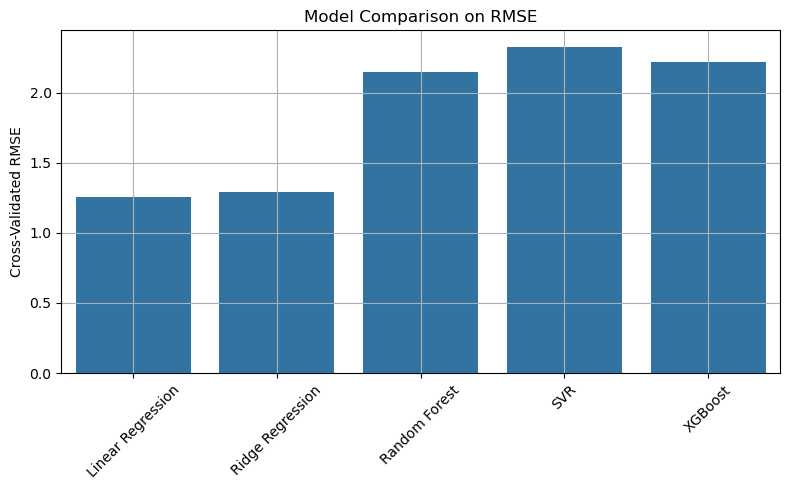

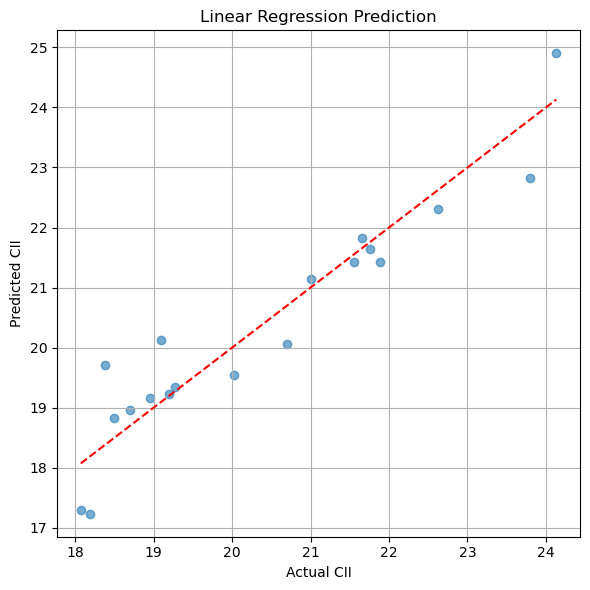

In [31]:
# RMSE comparison plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Cross-Validated RMSE")
plt.xticks(rotation=45)
plt.title("Model Comparison on RMSE")
plt.tight_layout()
plt.grid(True)
plt.show()

# Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred, alpha=0.6)
plt.xlabel("Actual CII")
plt.ylabel("Predicted CII")
plt.title(f"{best_model_name} Prediction")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid()
plt.tight_layout()
plt.show()

In [32]:
# Dictionary to store best models and their RMSEs
tuned_results = {}
best_models = {}

In [33]:
# 1. Linear Regression (no tuning)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
tuned_results['Linear Regression'] = lr_rmse
best_models['Linear Regression'] = lr_model

In [34]:
# 2. Ridge Regression
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)
ridge_pred = ridge_grid.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
tuned_results['Ridge Regression'] = ridge_rmse
best_models['Ridge Regression'] = ridge_grid.best_estimator_

In [35]:
# 3. Random Forest
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=5, scoring='neg_root_mean_squared_error')
rf_grid.fit(X_train, y_train)  # RF doesn't need scaling
rf_pred = rf_grid.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
tuned_results['Random Forest'] = rf_rmse
best_models['Random Forest'] = rf_grid.best_estimator_

In [36]:
# 4. SVR
svr_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1]}
svr_grid = GridSearchCV(SVR(), svr_params, cv=5, scoring='neg_root_mean_squared_error')
svr_grid.fit(X_train_scaled, y_train)
svr_pred = svr_grid.predict(X_test_scaled)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
tuned_results['SVR'] = svr_rmse
best_models['SVR'] = svr_grid.best_estimator_

In [37]:
# 5. XGBoost
xgb_params = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(XGBRegressor(random_state=0), xgb_params, cv=5, scoring='neg_root_mean_squared_error')
xgb_grid.fit(X_train, y_train)  # XGB can work unscaled
xgb_pred = xgb_grid.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
tuned_results['XGBoost'] = xgb_rmse
best_models['XGBoost'] = xgb_grid.best_estimator_

In [38]:
mae_scores = {}
r2_scores = {}

for name, model in best_models.items():
    if name == 'Random Forest' or name == 'XGBoost':
        preds = model.predict(X_test)
    else:
        preds = model.predict(X_test_scaled)

    # These are additional scores beyond RMSE
    mae_scores[name] = mean_absolute_error(y_test, preds)
    r2_scores[name] = r2_score(y_test, preds)

summary_df = pd.DataFrame({
    'RMSE': tuned_results,
    'MAE': mae_scores,
    'R2 Score': r2_scores
}).T.round(4)

print("\n Model Performance Metrics:")
print(summary_df)

    


 Model Performance Metrics:
          Linear Regression  Ridge Regression  Random Forest     SVR  XGBoost
RMSE                 0.6123            0.6073         0.9883  0.7647   1.2708
MAE                  0.4815            0.4779         0.8665  0.5900   1.1250
R2 Score             0.8913            0.8930         0.7167  0.8304   0.5316


In [39]:
#Train Final Ridge Model
ridge_final = Ridge(alpha=1.0)  # Use best alpha from previous tuning
ridge_final.fit(X_train_scaled, y_train)
y_pred = ridge_final.predict(X_test_scaled)
full_scaled = scaler.transform(daily_df[features])  # reuse the same scaler used during training
daily_df['Predicted_CII'] = ridge_final.predict(full_scaled)

In [40]:
#Evaluation/verification
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final Ridge Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

Final Ridge Model Performance:
RMSE: 0.6350
MAE:  0.4730
R2:   0.8830


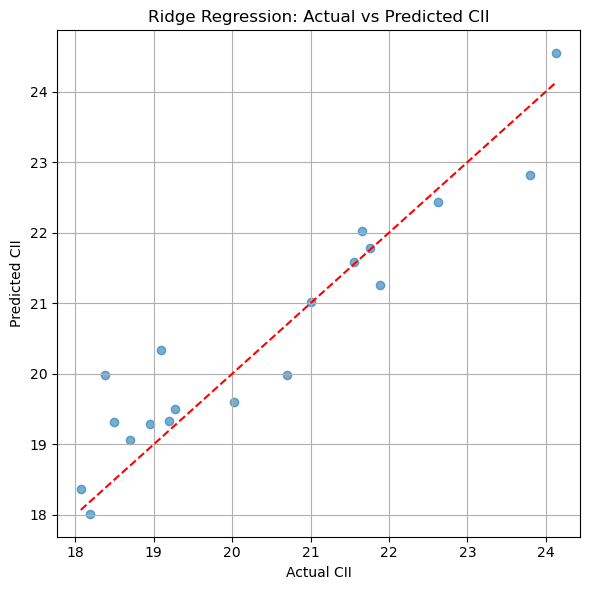

In [41]:
#Actual vs Predicted Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CII")
plt.ylabel("Predicted CII")
plt.title("Ridge Regression: Actual vs Predicted CII")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# --- Assign Ratings Based on Percentiles (Relative Ranking) ---

cii_values = daily_df['Predicted_CII']

# Define thresholds
a_th = np.percentile(cii_values, 20)
b_th = np.percentile(cii_values, 40)
c_th = np.percentile(cii_values, 60)
d_th = np.percentile(cii_values, 80)

# Rating logic
def assign_rating(cii):
    if cii <= a_th:
        return 'A'
    elif cii <= b_th:
        return 'B'
    elif cii <= c_th:
        return 'C'
    elif cii <= d_th:
        return 'D'
    else:
        return 'E'

In [43]:
# Apply
daily_df['Relative_Rating'] = daily_df['Predicted_CII'].apply(assign_rating)

# View rating summary
rating_counts = daily_df['Relative_Rating'].value_counts().sort_index()
print("\nRelative Rating Distribution:")
print(rating_counts)

# Save for validation
daily_df.to_csv('daily_summary_with_relative_ratings.csv', index=False)



Relative Rating Distribution:
Relative_Rating
A    19
B    18
C    18
D    18
E    19
Name: count, dtype: int64


In [44]:
def generate_suggestion(row):
    suggestions = []

    if row['Avg_Trim'] > 1.0:
        suggestions.append("Reduce trim to improve fuel efficiency")
    if row['Avg_Heel'] > 0.5:
        suggestions.append("Balance ballast to reduce heel")
    if row['Avg_Wind_Speed'] > 12:
        suggestions.append("Avoid sailing during high wind")
    if row['Avg_CppPitch'] < 15:
        suggestions.append("Increase CPP pitch for propulsion efficiency")
    if row['Avg_Speed'] < 17:
        suggestions.append("Maintain optimal cruising speed")
    
    return "; ".join(suggestions) if suggestions else "Performance is within expected range"

# Apply
daily_df['Optimization_Suggestions'] = daily_df.apply(generate_suggestion, axis=1)

In [45]:
daily_df[['Day', 'Predicted_CII', 'Relative_Rating', 'Optimization_Suggestions']].to_csv("cii_recommendations.csv", index=False)


In [49]:
use_manual_input = input("Use manual input? (yes/no): ").strip().lower()
if use_manual_input == 'yes':
    print("Enter today's average values:")
    row = pd.DataFrame([{
        'CO2_Emission_g': float(input("CO2 Emission (g): ")),
        'Distance_NM': float(input("Distance (NM): ")),
        'Avg_Speed': float(input("Avg Speed: ")),
        'Avg_Wind_Speed': float(input("Wind Speed: ")),
        'Avg_CppPitch': float(input("CPP Pitch: ")),
        'Avg_Heel': float(input("Heel: ")),
        'Avg_Trim': float(input("Trim: ")),
        'Avg_Draft': float(input("Avg Draft: "))
    }])
    row_scaled = scaler.transform(row)
    pred = ridge_final.predict(row_scaled)[0]
    print(f"Predicted CII: {pred:.4f} | Rating: {assign_rating(pred)}")
    print("Suggestions:", generate_suggestion(row.iloc[0]))
else:
    file_path = input("CSV file path: ").strip()
    data = pd.read_csv(file_path)
    preds = ridge_final.predict(scaler.transform(data[features]))
    data['Predicted_CII'] = preds
    data['Rating'] = data['Predicted_CII'].apply(assign_rating)
    data['Suggestions'] = data.apply(generate_suggestion, axis=1)
    print(data[['Predicted_CII', 'Rating', 'Suggestions']])
    data.to_csv("cii_predictions_output.csv", index=False)
    print("Saved to cii_predictions_output.csv")

    Predicted_CII Rating                                        Suggestions
0       17.055108      A               Performance is within expected range
1       17.961730      A               Performance is within expected range
2       18.878656      A               Performance is within expected range
3       19.136552      A               Performance is within expected range
4       17.771170      A               Performance is within expected range
5       27.129513      E  Reduce trim to improve fuel efficiency; Avoid ...
6       26.505928      E  Reduce trim to improve fuel efficiency; Avoid ...
7       27.929322      E  Reduce trim to improve fuel efficiency; Mainta...
8       26.755834      E  Reduce trim to improve fuel efficiency; Avoid ...
9       26.653862      E  Reduce trim to improve fuel efficiency; Avoid ...
10      20.925353      D                    Maintain optimal cruising speed
11      23.261903      E                    Maintain optimal cruising speed
12      21.3